# Método de revisão *Impresso*

Esse notebook[^1] foi desenvolvido por  Ehrmann, Maud, Estelle Bunout, e Marten Düring e apresenta um método de avaliação de interfaces gráficas de jornais históricos (2019). Os resultados da pesquisa foram publicados 2017 no artigo [Historical Newspaper User Interfaces: A Review](http://library.ifla.org/id/eprint/2578/).

Busco aqui aplicar o mesmo método a partir dos dados das três hemerotecas estudadas: Hemeroteca Digital da Biblioteca Nacional, Hemeroteca Digital da Biblioteca Nacional de Portugal, Hemeroteca Municipal de Lisboa. Corresponde à parte da pesquisa de **pós-doutorado** desenvolvida no **Instituto de História Contemporânea (IHC)**[^2] da **Faculdade de Ciências Sociais e Humanas da Universidade NOVA de Lisboa**, no **Laboratório de Humanidades Digitais**, entre **outubro de 2022 e outubro de 2023**, sob a supervisão do **Prof. Dr. Daniel Alves**.

Os resultados completos do estágio pós-doutoral estão disponíveis no Jupyter Book:

- https://ericbrasil.com.br/hemdig-framework  
- Brasil, E. (2023). *HEMDIG(pt) Framework: Métodos, ferramentas e hemerotecas digitais em português* (Version v1.0.0). Jupyter Book. https://doi.org/10.5281/zenodo.8397782

Os gráficos gerados estão armazenados em [`charts/`](../charts/).

[^1]: Maud Ehrmann, Estelle Bunout, and Marten Düring. “Survey of Digitized Newspaper Interfaces (dataset and Notebooks)”. Zenodo, August 16, 2019. https://doi.org/10.5281/zenodo.3369875.

[^2]: O IHC é financiado por fundos nacionais através da **FCT — Fundação para a Ciência e a Tecnologia, I.P.**, no âmbito dos projetos UIDB/04209/2020, UIDP/04209/2020, LA/P/0132/2020

## Versão adaptada para o artigo publicado na revista Matraga

Esta versão adaptada do código para geração de gráficos radar foi desenvolvida especificamente para os dados apresentados no artigo *"INTERFACES DE HEMEROTECAS DIGITAIS EM PORTUGUÊS: análise crítica e desafios para o desenvolvimento de uma nova geração de acervos históricos"*, de autoria de **Eric Brasil**, publicado na revista **Matraga**.

A citação completa do artigo será incluída assim que estiver disponível.


In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from radar_factory import build_single_radar, build_multiple_radar, build_single_radar_free

## Preparing data
#### Loading the review spreasheet as a multi-index (tsv)

In [2]:
base = pd.read_csv("../data/InterfaceReview-pt-2023.csv", sep="\t", index_col= [0,1], skipinitialspace=True)

In [3]:
base.head()

Hemeroteca Digital Brasileira (HDB)  \
Property family Property                                                                          
interface       URL                                                   http://memoria.bn.br/hdb/   
                Target area                                                                  BR   
                Creator                                            Fundação Biblioteca Nacional   
                Purpose and scope             Coleção de periódicos digitalizados do acervo ...   
                Approximate date of creation                                               2012   

                                               Biblioteca Nacional Digital de Portugal (BND-PT)  \
Property family Property                                                                          
interface       URL                                        https://bndigital.bnportugal.gov.pt/   
                Target area                                                                  PT   
                Creator                                         Biblioteca Nacional de Portugal   
                Purpose and scope             Acervo digitalizado da Biblioteca Nacional de ...   
                Approximate date of creation                                                  u   

                                                             Hemeroteca Digital de Lisboa (HDL)  
Property family Property                                                                         
interface       URL                                     https://hemerotecadigital.cm-lisboa.pt/  
                Target area                                                                  PT  
                Creator                                                   Bibliotecas de Lisboa  
                Purpose and scope             Periódicos, legislação obras raras digitalizad...  
                Approximate date of creation                                                  u

#### Testing some indexing

In [4]:
# about multilingual collections
base.loc['newspaper collection', 'Languages of the collections'].value_counts()

(newspaper collection, Languages of the collections)
pt    3
Name: count, dtype: int64

In [5]:
# about access model
base.loc['interface', 'Access model'].value_counts()

(interface, Access model)
free    3
Name: count, dtype: int64

In [6]:
# about Interface provider
base.loc['interface', 'Interface provider'].value_counts()

(interface, Interface provider)
Instituição Pública    2
Private (DocPro)       1
Name: count, dtype: int64

#### Some cleaning and preparation

In [7]:
def trim_all_columns(df):
    """
    Trim whitespace from ends of each value across all series in dataframe
    """
    trim_strings = lambda x: x.strip() if type(x) is str else x
    return df.applymap(trim_strings)


In [8]:
# trim
base = trim_all_columns(base)

# removing non binary features
base = base.drop('interface', level=0)
base = base.drop('newspaper collection', level=0)
base = base.drop('Languages of the collections', level=1) # from 'newspaper collection'

base = base.drop('Other', level=1)
base = base.drop('Download options (file formats)', level=1)

#Replace n and y by 0 and 1 
base = base.replace(to_replace=['y', 'y?', 'y (annotations)', 'y (requires user account - free)', 'n', '?', 'u', 'n?', 'n (?)', 'n (but can signal mistakes)'], 
                    value=[1,1,1,1,0,0,0,0,0,0])

/tmp/ipykernel_485023/1114679381.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(trim_strings)
/tmp/ipykernel_485023/16062821.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base = base.replace(to_replace=['y', 'y?', 'y (annotations)', 'y (requires user account - free)', 'n', '?', 'u', 'n?', 'n (?)', 'n (but can signal mistakes)'],


In [9]:
base.head()

Hemeroteca Digital Brasileira (HDB)  \
Property family    Property                                                    
newspaper metadata Alternative titles                                      0   
                   Place of publication                                    1   
                   Geographic coverage                                     1   
                   Publisher                                               0   
                   Date range                                              1   

                                         Biblioteca Nacional Digital de Portugal (BND-PT)  \
Property family    Property                                                                 
newspaper metadata Alternative titles                                                   1   
                   Place of publication                                                 1   
                   Geographic coverage                                                  0   
                   Publisher                                                            1   
                   Date range                                                           1   

                                         Hemeroteca Digital de Lisboa (HDL)  
Property family    Property                                                  
newspaper metadata Alternative titles                                     1  
                   Place of publication                                   1  
                   Geographic coverage                                    0  
                   Publisher                                              1  
                   Date range                                             1

## Interface charts
### Generic counts

Vamos trabalhar com valores inteiros pelo pequeno número de interfaces analisadas.

In [10]:
base.loc[:,'Total'] = base.sum(axis=1, numeric_only=True)

In [11]:
base.head()

Hemeroteca Digital Brasileira (HDB)  \
Property family    Property                                                    
newspaper metadata Alternative titles                                      0   
                   Place of publication                                    1   
                   Geographic coverage                                     1   
                   Publisher                                               0   
                   Date range                                              1   

                                         Biblioteca Nacional Digital de Portugal (BND-PT)  \
Property family    Property                                                                 
newspaper metadata Alternative titles                                                   1   
                   Place of publication                                                 1   
                   Geographic coverage                                                  0   
                   Publisher                                                            1   
                   Date range                                                           1   

                                         Hemeroteca Digital de Lisboa (HDL)  \
Property family    Property                                                   
newspaper metadata Alternative titles                                     1   
                   Place of publication                                   1   
                   Geographic coverage                                    0   
                   Publisher                                              1   
                   Date range                                             1   

                                         Total  
Property family    Property                     
newspaper metadata Alternative titles        2  
                   Place of publication      3  
                   Geographic coverage       1  
                   Publisher                 2  
                   Date range                3

#### Group by for aggregated counts

In [12]:
# Sum values of level 1 => 'grade' of each interface per family of features
level_0 = base.groupby(level=0).sum()

#level_0 = base.groupby(level=0).sum(numeric_only=True)

# re-order index
level_0 = level_0.reindex(["newspaper metadata", 
                 "apis",
                 "connectivity",
                 "info on digitization",
                 "enrichment",
                 "user interaction",
                 "viewer",
                 "result display",
                 "result filtering",
                 "result sorting",
                 "search",
                 "browsing"
                    ])


In [13]:
# copy level_0 to analyze
level_0_copy = level_0.copy()

In [14]:
level_0_copy

Hemeroteca Digital Brasileira (HDB)  \
Property family                                             
newspaper metadata                                      4   
apis                                                    0   
connectivity                                            0   
info on digitization                                    1   
enrichment                                              0   
user interaction                                        1   
viewer                                                  6   
result display                                          3   
result filtering                                        3   
result sorting                                          2   
search                                                  6   
browsing                                                3   

                      Biblioteca Nacional Digital de Portugal (BND-PT)  \
Property family                                                          
newspaper metadata                                                   9   
apis                                                                 0   
connectivity                                                         1   
info on digitization                                                 1   
enrichment                                                           0   
user interaction                                                     1   
viewer                                                               8   
result display                                                       3   
result filtering                                                     6   
result sorting                                                       4   
search                                                              11   
browsing                                                             4   

                      Hemeroteca Digital de Lisboa (HDL)  Total  
Property family                                                  
newspaper metadata                                     8     21  
apis                                                   0      0  
connectivity                                           0      1  
info on digitization                                   0      2  
enrichment                                             0      0  
user interaction                                       0      2  
viewer                                                 4     18  
result display                                         1      7  
result filtering                                       0      9  
result sorting                                         0      6  
search                                                 0     17  
browsing                                               4     11

In [15]:
# getting the labels
labels = level_0_copy.index

#### Test radar with one interface

In [ ]:
# Get all rows, just for the first columns, transpose it (for the radar factory) and take only the values
first_interface = level_0_copy.iloc[:12, :1].T.values

In [17]:
# Get all rows, just for the second column, transpose it (for the radar factory) and take only the values
second_interface = level_0_copy.iloc[:12, 1:2].T.values

In [20]:
# Get all rows, just for the third column, transpose it (for the radar factory) and take only the values
third_interface = level_0_copy.iloc[:12, 2:3].T.values

### HDB

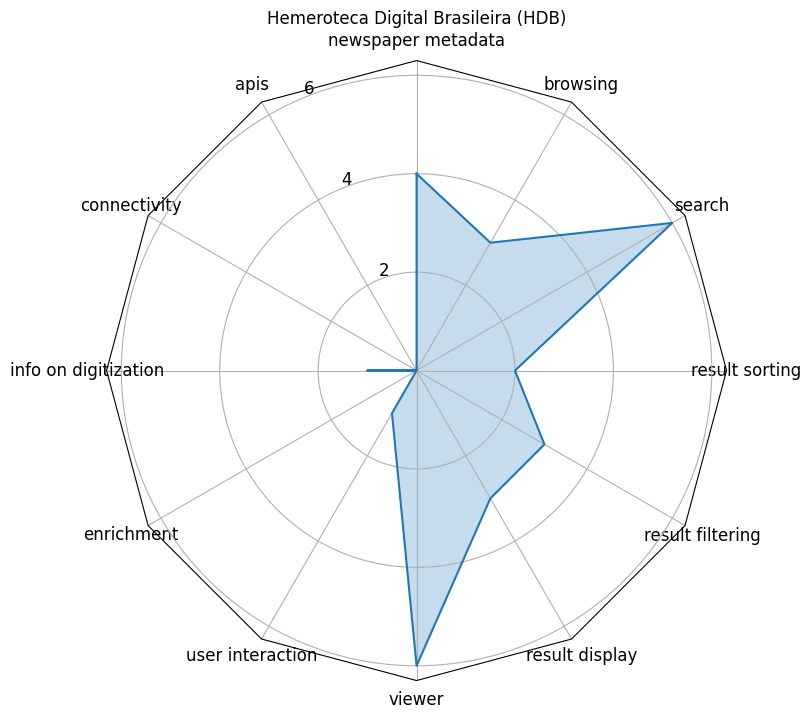

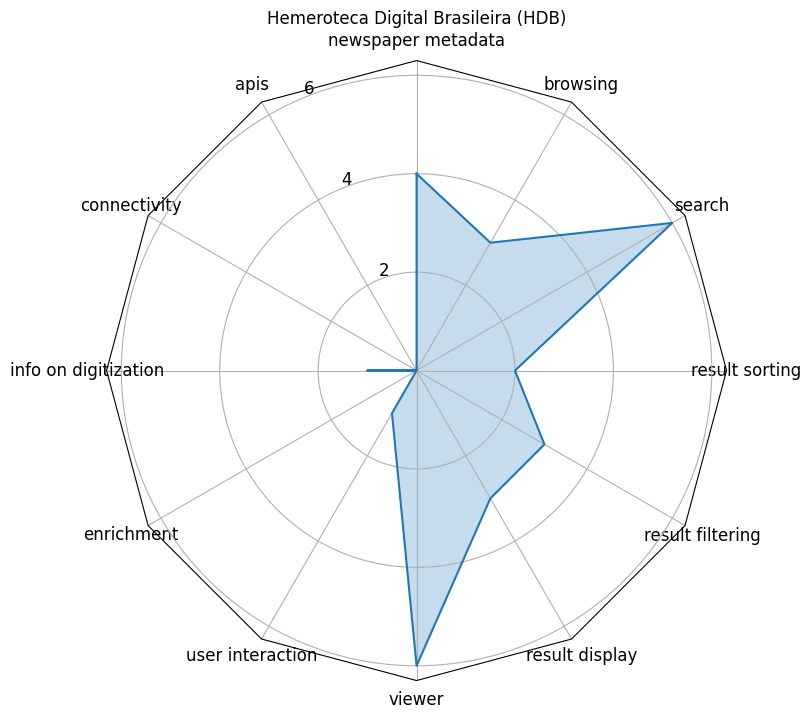

In [18]:
build_single_radar(labels, values=first_interface, title=level_0_copy.columns[0], grid=[2,4,6,8], figure_title='HDB', output_type='pdf')
build_single_radar(labels, values=first_interface, title=level_0_copy.columns[0], grid=[2,4,6,8], figure_title='HDB', output_type='png')


### BND-PT

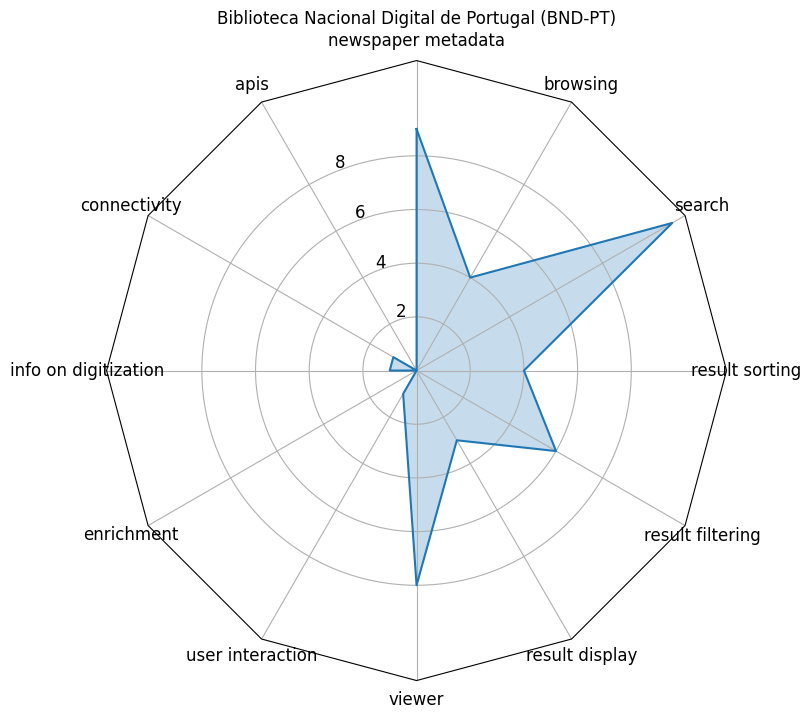

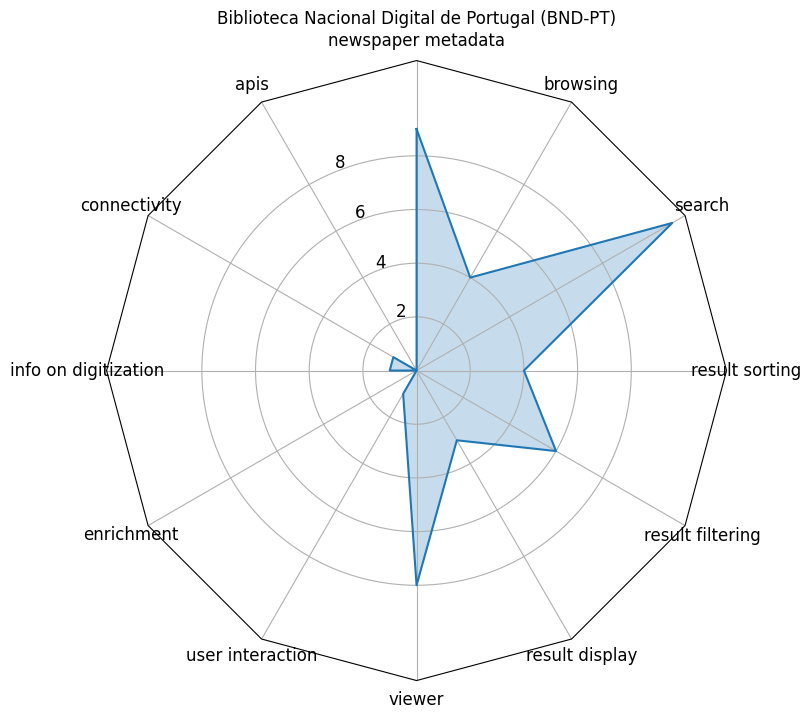

In [19]:
build_single_radar(labels, values=second_interface, title=level_0_copy.columns[1], grid=[2,4,6,8], figure_title='BND-PT', output_type='png')
build_single_radar(labels, values=second_interface, title=level_0_copy.columns[1], grid=[2,4,6,8], figure_title='BND-PT', output_type='pdf')

### HML

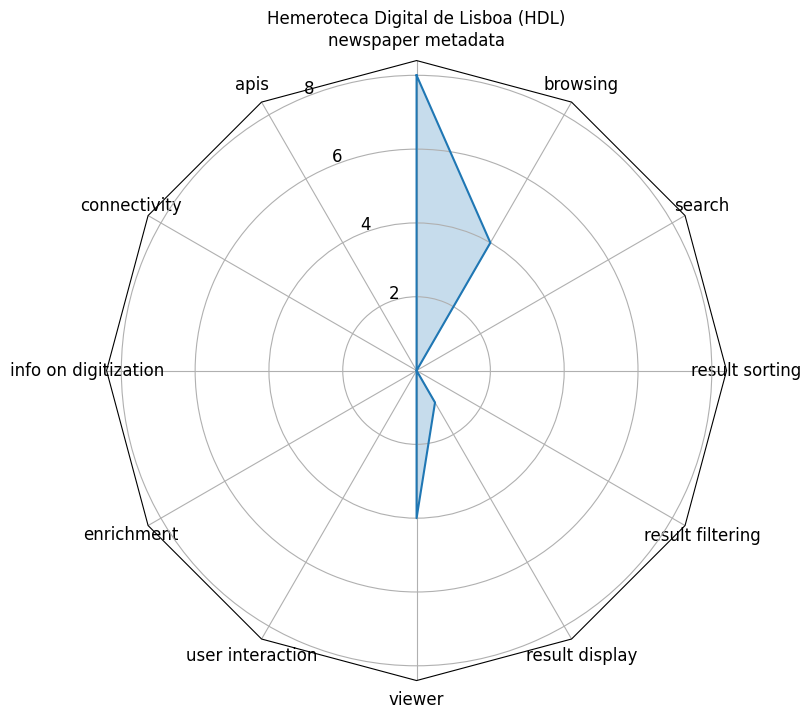

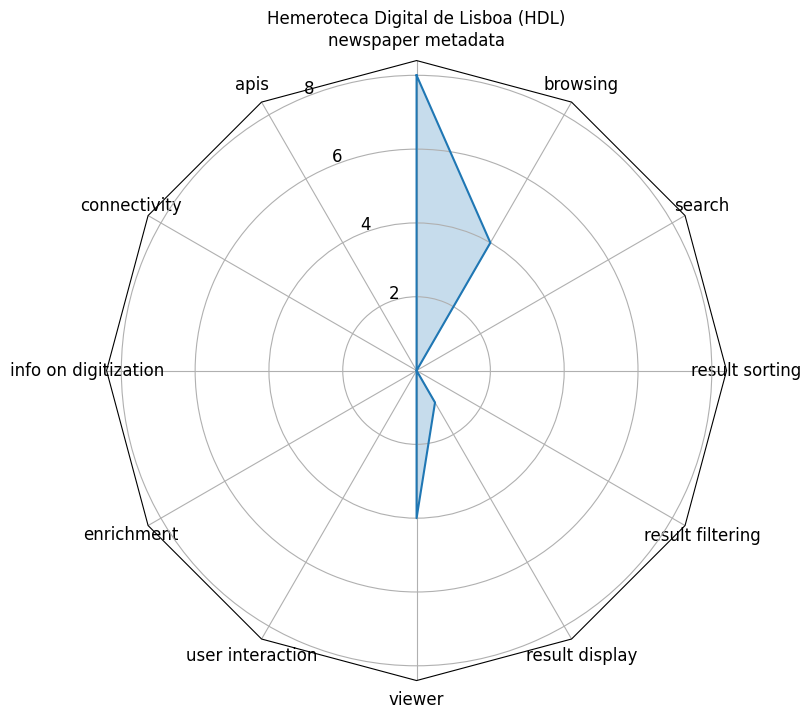

In [21]:
build_single_radar(labels, values=third_interface, title=level_0_copy.columns[2], grid=[2,4,6,8], figure_title='HML', output_type='png')
build_single_radar(labels, values=third_interface, title=level_0_copy.columns[2], grid=[2,4,6,8], figure_title='HML', output_type='pdf')


### Radar view for each interface in one figure

Vamos trabalhar com valores inteiros pelo pequeno número de interfaces analisadas.

In [20]:
all_interfaces_percents = level_0_copy.iloc[:12, :].T.values

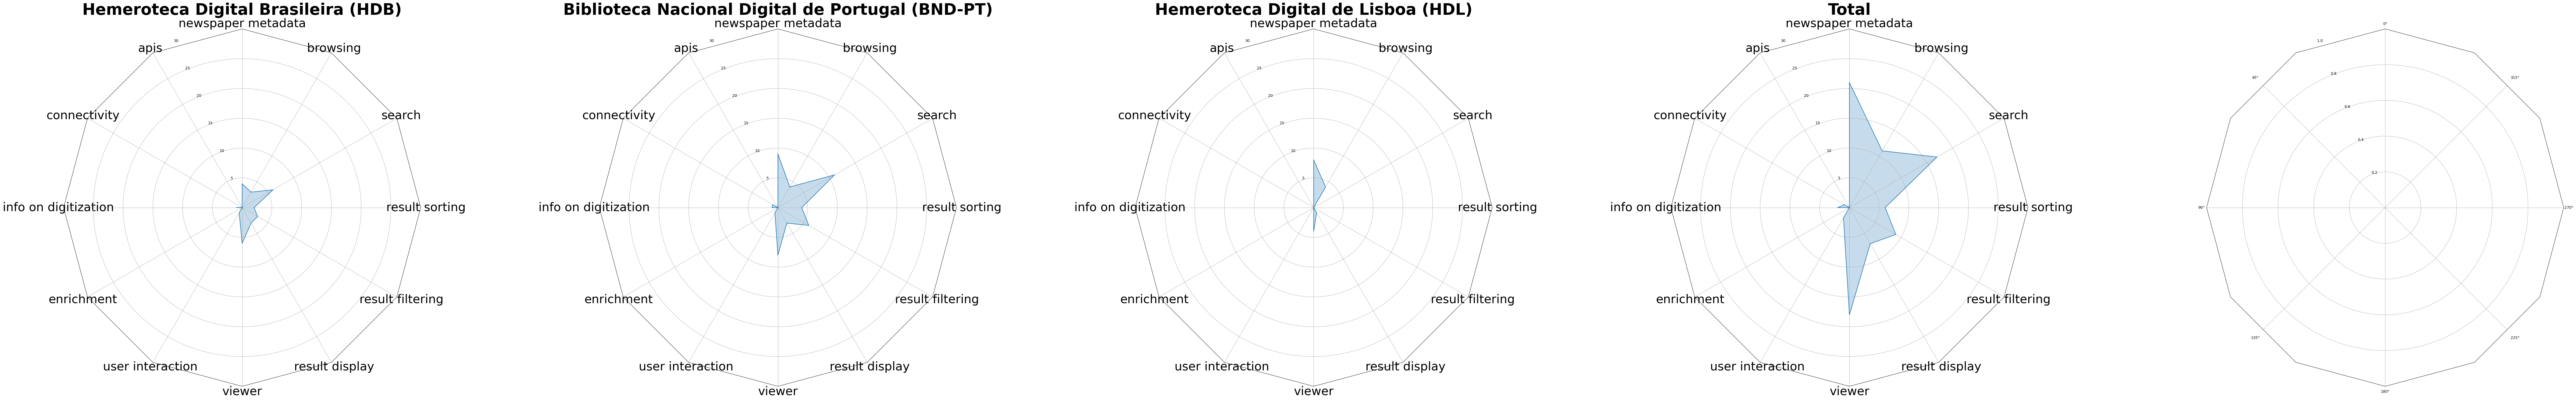

In [21]:
build_multiple_radar(labels, all_interfaces_percents, level_0_copy.columns[:], 'all-interfaces-single', output_type='png')

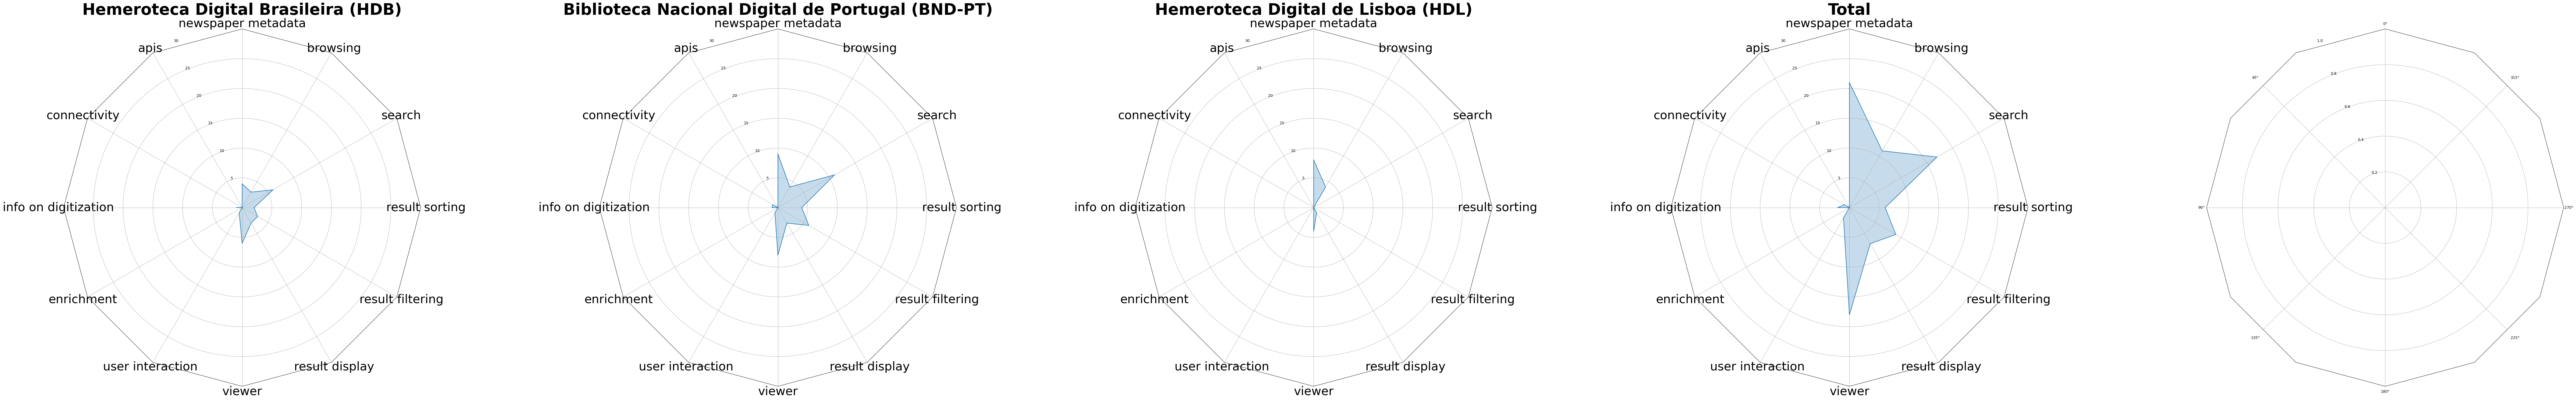

In [22]:
build_multiple_radar(labels, all_interfaces_percents, level_0_copy.columns[:], 'all-interfaces-single', output_type='pdf')

#### Global radar view (i.e. for all interfaces) over all features

In [23]:
level_0_copy.iloc[:,3]

Property family
newspaper metadata      21
apis                     0
connectivity             1
info on digitization     2
enrichment               0
user interaction         2
viewer                  18
result display           7
result filtering         9
result sorting           6
search                  17
browsing                11
Name: Total, dtype: int64

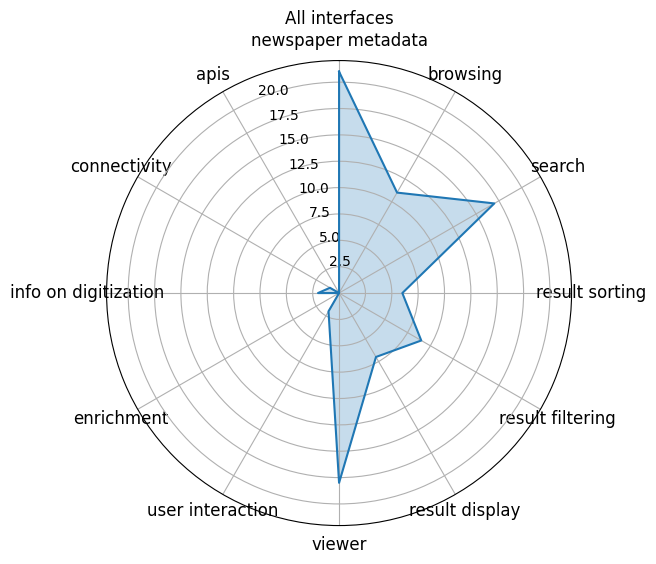

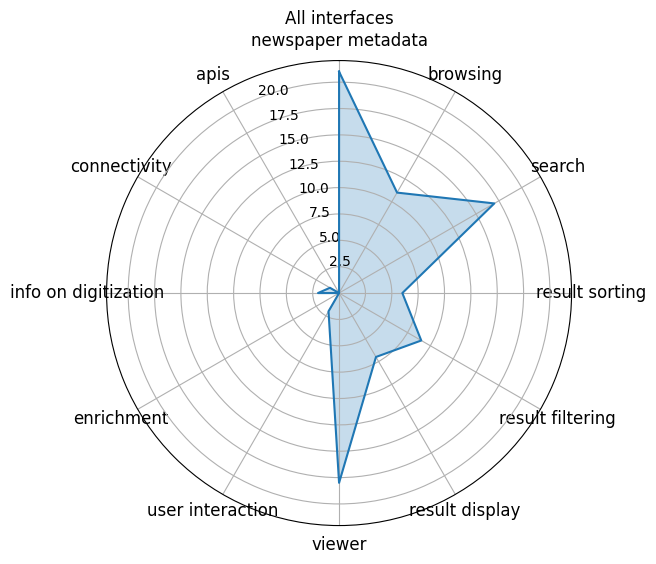

In [24]:
# take only the last column: Total per feature family, in absolute numbers
values = level_0_copy.iloc[:,3:].T.values
build_single_radar_free(labels, values, "All interfaces",figure_title='all-interfaces-global', output_type='png')
build_single_radar_free(labels, values, "All interfaces",figure_title='all-interfaces-global', output_type='pdf')

#### Metadata (global)

In [25]:
metadata = base.loc['newspaper metadata'].copy()
metadata.loc[:,'Total'] = metadata.iloc[:, :3].sum(axis=1)
metadata.loc[:,'Total']

Property
Alternative titles              2
Place of publication            3
Geographic coverage             1
Publisher                       2
Date range                      3
Periodicity                     1
ISSN, OCLC, LCCN                0
External links                  2
Historical description          1
Language                        1
Calendar view of issues         2
Indication of archive holder    3
Name: Total, dtype: int64

In [26]:
metadata.shape[0]

12

In [27]:
metadata['Total']

Property
Alternative titles              2
Place of publication            3
Geographic coverage             1
Publisher                       2
Date range                      3
Periodicity                     1
ISSN, OCLC, LCCN                0
External links                  2
Historical description          1
Language                        1
Calendar view of issues         2
Indication of archive holder    3
Name: Total, dtype: int64

In [28]:
metadata.sort_values('Total').loc[:, 'Total']

Property
ISSN, OCLC, LCCN                0
Geographic coverage             1
Periodicity                     1
Historical description          1
Language                        1
Publisher                       2
External links                  2
Alternative titles              2
Calendar view of issues         2
Place of publication            3
Date range                      3
Indication of archive holder    3
Name: Total, dtype: int64

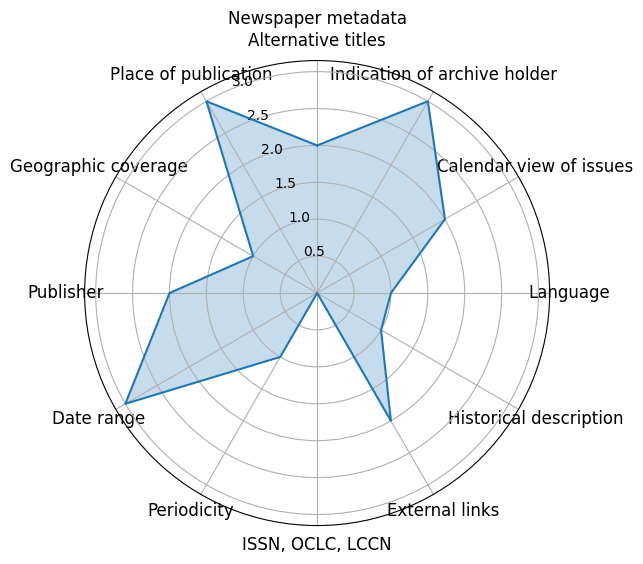

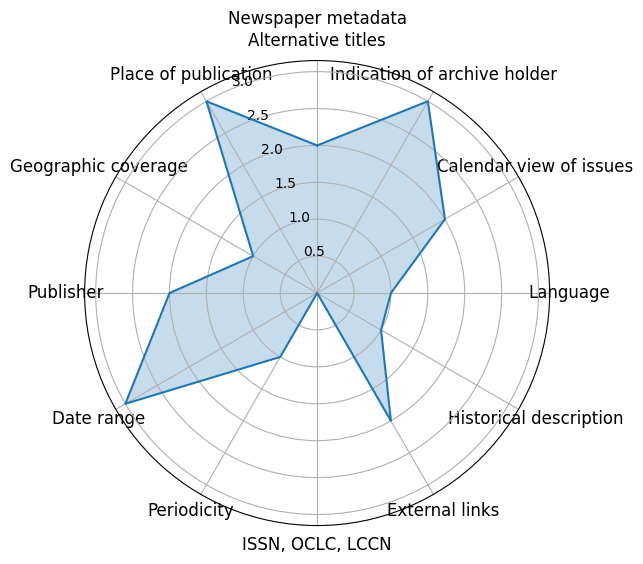

In [29]:
values_metadata = metadata.iloc[:,3:].T.values
build_single_radar_free(metadata.index, values_metadata, title="Newspaper metadata", figure_title="metadata-global", output_type='png')
build_single_radar_free(metadata.index, values_metadata, title="Newspaper metadata", figure_title="metadata-global", output_type='pdf')

#### Browsing

In [30]:
browsing = base.loc['browsing'].copy()
browsing.loc[:,'Total'] = browsing.iloc[:, :3].sum(axis=1)
browsing.loc[:,'Total']

Property
By date                             3
By title                            3
By place of publication             3
By user tag                         0
By newspaper thematic (metadata)    2
Name: Total, dtype: int64

In [31]:
browsing.shape[0]

5

In [32]:
browsing.sort_values('Total').loc[:, 'Total']

Property
By user tag                         0
By newspaper thematic (metadata)    2
By title                            3
By date                             3
By place of publication             3
Name: Total, dtype: int64

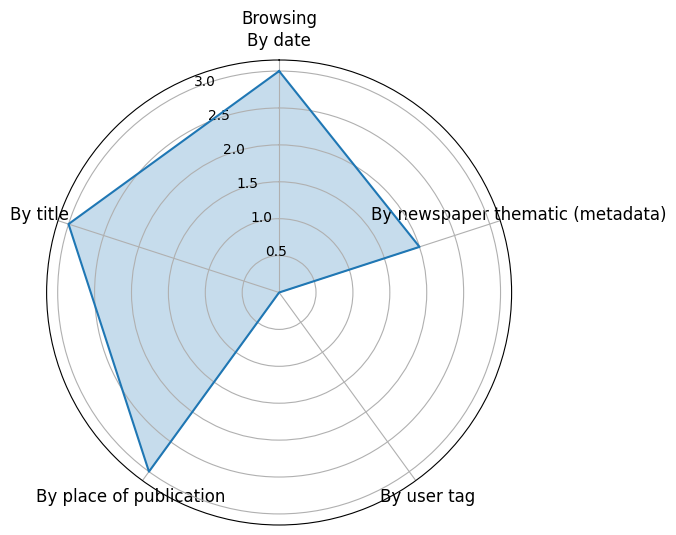

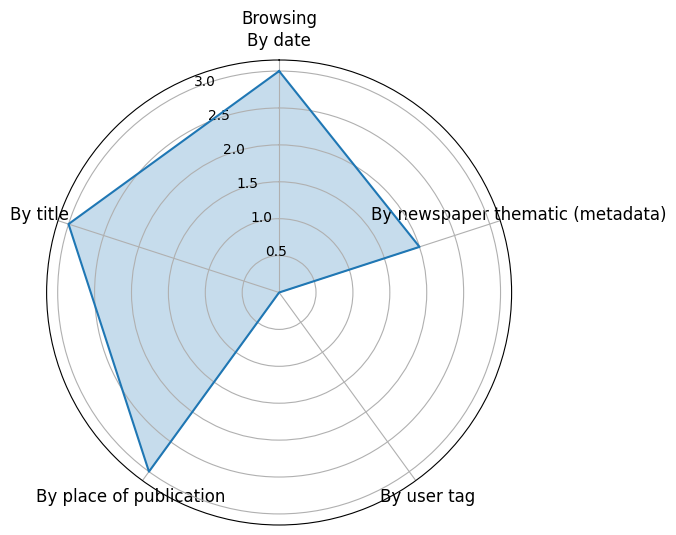

In [33]:
values_browsing = browsing.iloc[:,3:].T.values
build_single_radar_free(browsing.index, values_browsing, title="Browsing", figure_title="browsing-global", output_type='png')
build_single_radar_free(browsing.index, values_browsing, title="Browsing", figure_title="browsing-global", output_type='pdf')

#### Search

In [34]:
search = base.loc['search'].copy()
search.loc[:,'Total'] = search.iloc[:, :3].sum(axis=1)
search['Total']

Property
Keyword search                          2
Query autocomplete                      1
Boolean operators                       1
Phrase search                           2
Fuzzy search                            0
Wild card                               2
Proximity search                        0
Limit by date range                     2
Limit by language                       1
Limit by NP title(s)                    2
Limit by place of publication           2
Limit by NP thematic (from metadata)    1
Limit by NP segments                    0
Limit by article category               0
Limit by article length                 0
Limit by archival holder                0
Limit by license                        1
Query suggestion                        0
Search by NE                            0
Name: Total, dtype: int64

In [35]:
search.shape[0]

19

In [36]:
search.sort_values('Total').loc[:, 'Total']

Property
Proximity search                        0
Fuzzy search                            0
Limit by article length                 0
Limit by archival holder                0
Limit by NP segments                    0
Limit by article category               0
Search by NE                            0
Query suggestion                        0
Limit by NP thematic (from metadata)    1
Limit by language                       1
Query autocomplete                      1
Boolean operators                       1
Limit by license                        1
Limit by date range                     2
Keyword search                          2
Phrase search                           2
Limit by NP title(s)                    2
Limit by place of publication           2
Wild card                               2
Name: Total, dtype: int64

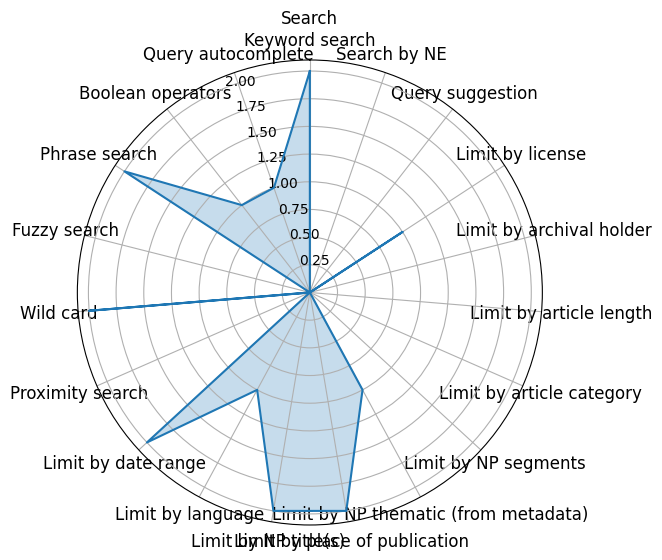

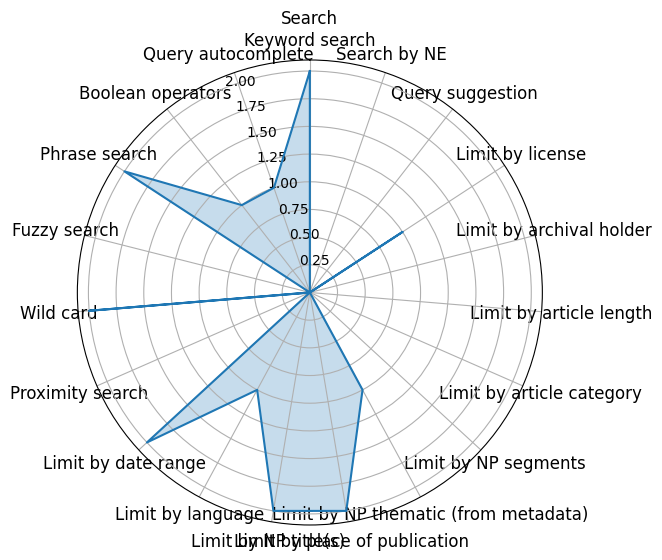

In [37]:
values_search = search.iloc[:,3:].T.values
build_single_radar_free(search.index, values_search, title="Search", figure_title="search-global", output_type='png')
build_single_radar_free(search.index, values_search, title="Search", figure_title="search-global", output_type='pdf')

#### Result display

In [38]:
rd = base.loc['result display'].copy()
rd.loc[:,'Total'] = rd.iloc[:, :3].sum(axis=1)
rd['Total']

Property
Distribution over time                     2
Distribution by publication place          0
Distribution by NP                         3
Distribution by place names in articles    0
Snippet preview                            1
Search highlight in facsimiles             1
Search highlight in text                   0
Ngrams                                     0
Name: Total, dtype: int64

In [39]:
rd.shape[0]

8

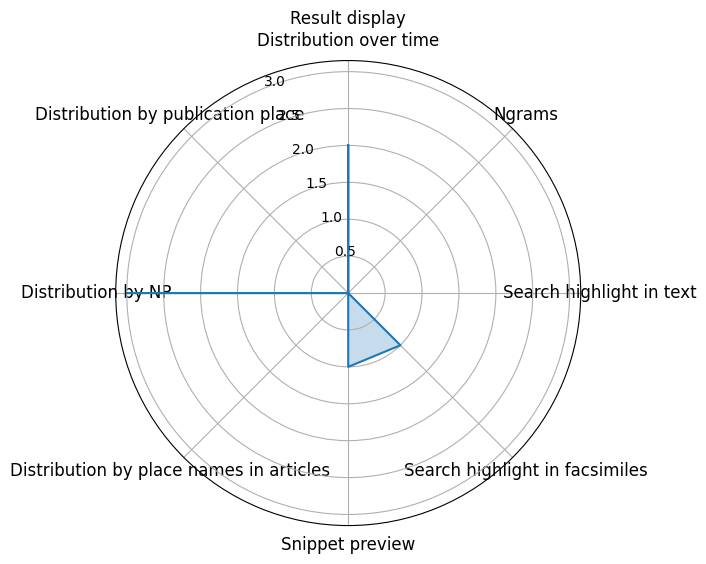

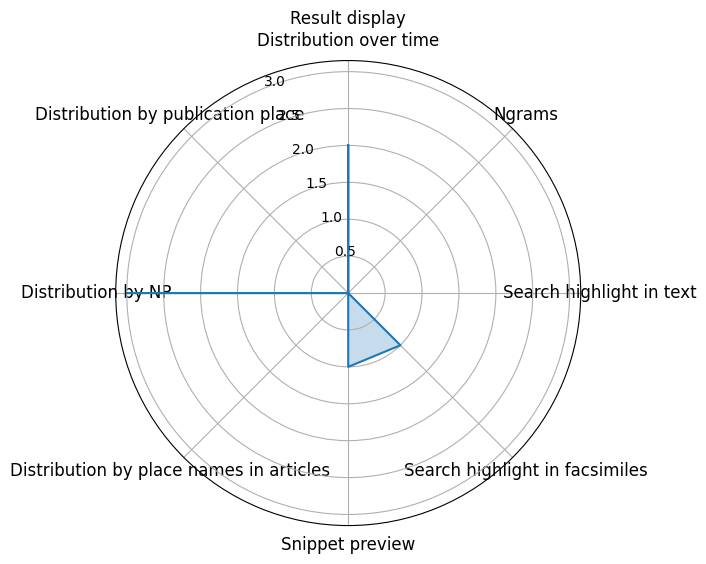

In [40]:
values_rd = rd.iloc[:,3:].T.values
build_single_radar_free(rd.index, values_rd, title="Result display", figure_title="result-display-global", output_type='png')
build_single_radar_free(rd.index, values_rd, title="Result display", figure_title="result-display-global", output_type='pdf')

#### Result filtering

In [41]:
rf = base.loc['result filtering'].copy()
rf.loc[:,'Total'] = rf.iloc[:, :3].sum(axis=1)
rf['Total']

Property
By NP titles                        1
By periodicity                      0
By NP orientation                   0
By newspaper thematic (metadata)    1
By content types                    1
By sections                         0
By events                           0
By persons                          0
By organisations                    0
By places mentioned in text         0
By time period                      2
By topics                           0
By manual tags                      0
By publication place                2
By archive                          0
By publisher                        0
By article length                   0
By authors                          0
By segmentation level               0
By language                         1
By license                          1
By online pub. date                 0
Name: Total, dtype: int64

In [42]:
rf.shape[0]

22

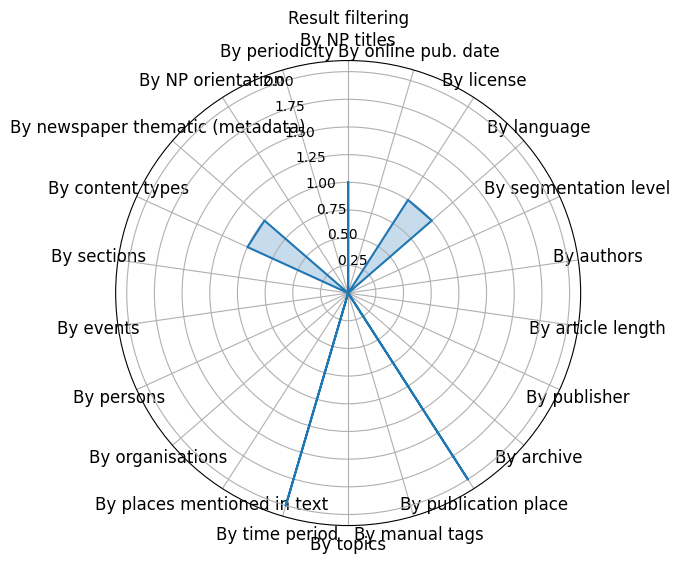

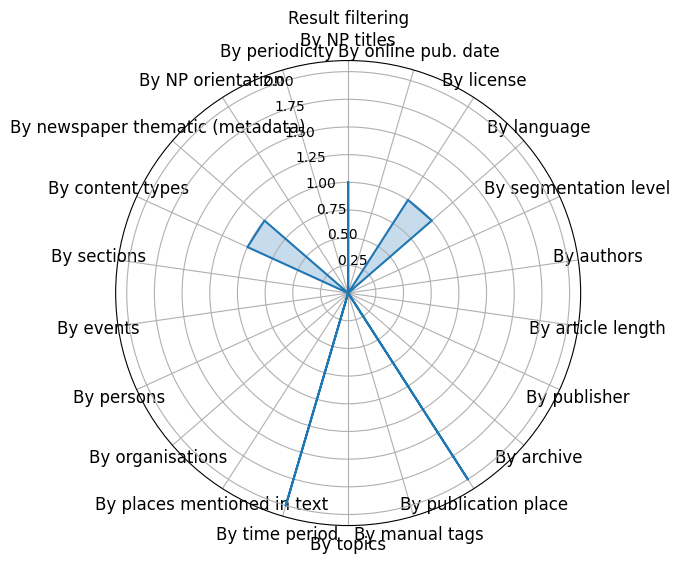

In [43]:
values_rf = rf.iloc[:,3:].T.values
build_single_radar_free(rf.index, values_rf, title="Result filtering", figure_title="result-filtering-global", output_type='png')
build_single_radar_free(rf.index, values_rf, title="Result filtering", figure_title="result-filtering-global", output_type='pdf')

#### Result sorting

In [44]:
rs = base.loc['result sorting'].copy()
rs.loc[:,'Total'] = rs.iloc[:, :3].sum(axis=1)
rs['Total']

Property
By relevance           1
By date                2
By NP title            2
By article title       0
By content type        0
By online pub. date    1
By author              0
By quality of text     0
By language            0
By popularity          0
Name: Total, dtype: int64

In [45]:
rs.shape[0]

10

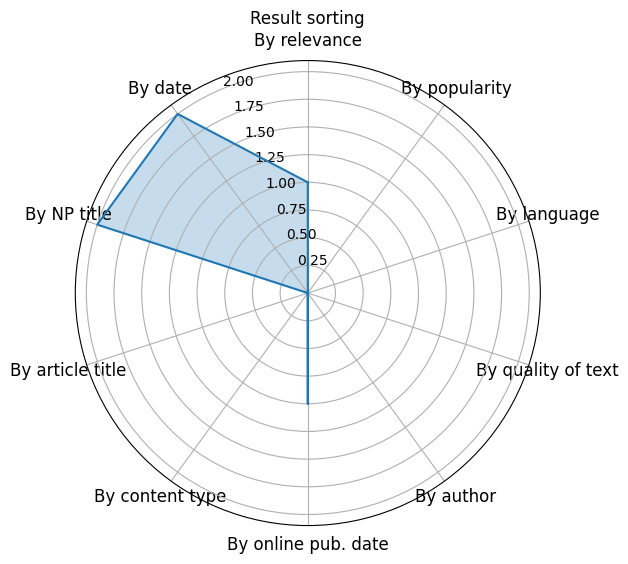

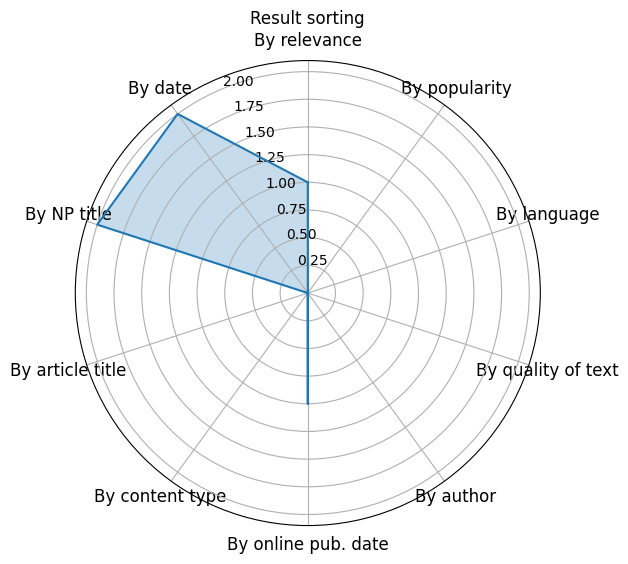

In [46]:
values_rs = rs.iloc[:,3:].T.values
build_single_radar_free(rs.index, values_rs, title="Result sorting", figure_title="result-sorting-global", output_type='png')
build_single_radar_free(rs.index, values_rs, title="Result sorting", figure_title="result-sorting-global", output_type='pdf')

#### Viewer

In [47]:
viewer = base.loc['viewer'].copy()
viewer.loc[:,'Total'] = viewer.iloc[:, :3].sum(axis=1)
viewer.loc[:,'Total']

Property
Facsimile displayed                  3
OCRed text display                   1
Show full page                       3
Interactive mini-map                 1
Overview of avail. issues            3
Search in viewed page                2
Option to continue to next page      3
Option to continue to next result    2
Name: Total, dtype: int64

In [48]:
viewer.shape[0]

8

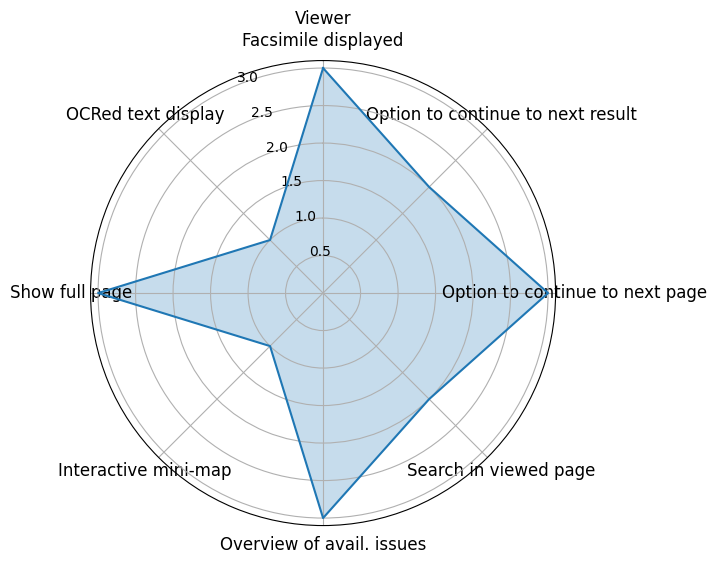

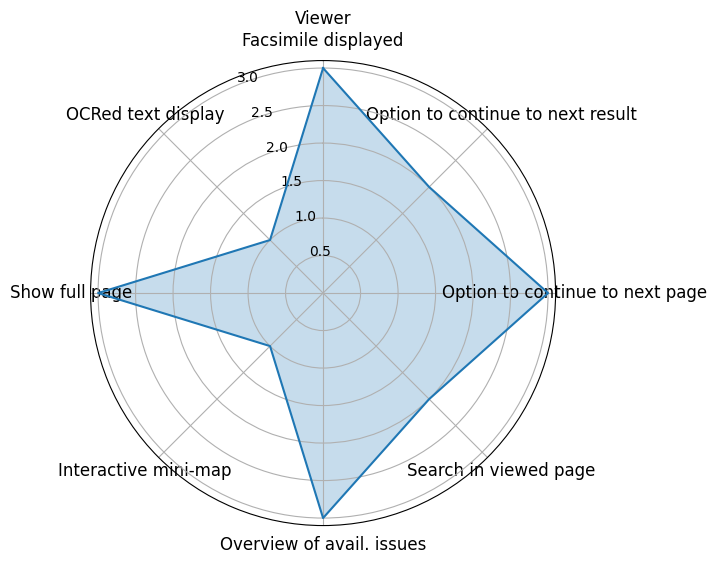

In [49]:
values_viewer = viewer.iloc[:,3:].T.values
build_single_radar_free(viewer.index, values_viewer, title="Viewer", figure_title="viewer-global", output_type='png')
build_single_radar_free(viewer.index, values_viewer, title="Viewer", figure_title="viewer-global", output_type='pdf')

#### Info on digitization

In [50]:
info = base.loc['info on digitization'].copy()
info.loc[:,'Total'] = info.iloc[:, :3].sum(axis=1)
info.loc[:,'Total']

Property
OLR at article level                0
OCR confidence scores               0
OLR confidence scores               0
Documentation of biases             0
Search result relevance score       0
Digitisation date at title level    0
Scan resolution                     0
Used OCR tools                      0
Copyright notice                    2
Documentation of scan methods       0
Name: Total, dtype: int64

In [51]:
info.shape[0]

10

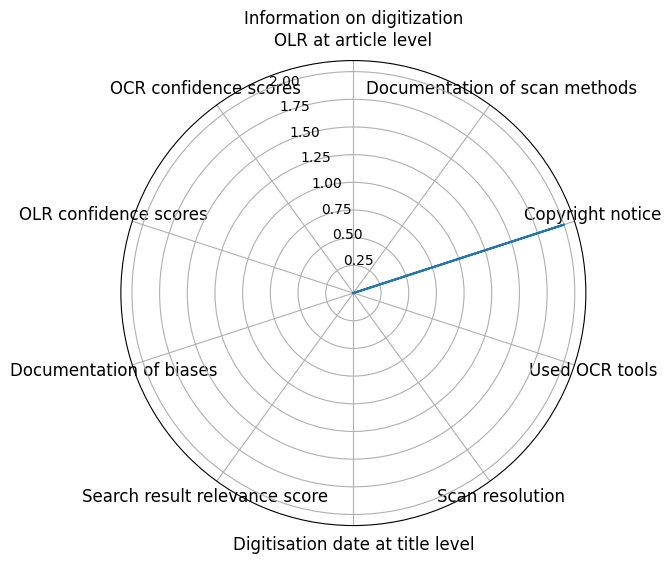

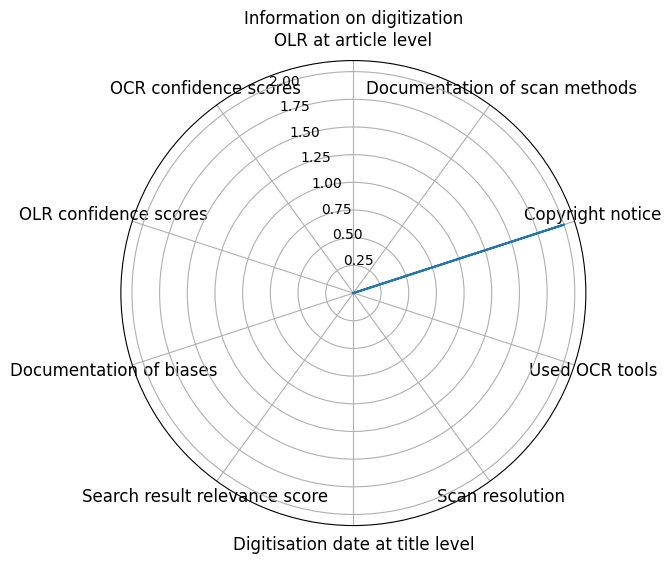

In [52]:
values_info = info.iloc[:,3:].T.values
build_single_radar_free(info.index, values_info, title="Information on digitization", figure_title="info-global", output_type='png')
build_single_radar_free(info.index, values_info, title="Information on digitization", figure_title="info-global", output_type='pdf')

#### User interaction 

In [53]:
user = base.loc['user interaction'].copy()
user.loc[:, 'Total'] = user.iloc[:, :3].sum(axis=1)
user['Total']

Property
Save articles to favorites          0
Save queries to favorites           0
Tag articles                        0
Keep track of viewed materials      0
Article recommendations             0
Permalinks                          2
Export citation                     0
Option to correct OCR               0
Option to correct OLR               0
Add/edit of metadata                0
Screenshot tool                     0
Bulk downloads                      0
Organise articles in collections    0
Contrastive view of collections     0
Name: Total, dtype: int64

In [54]:
user.shape[0]

14

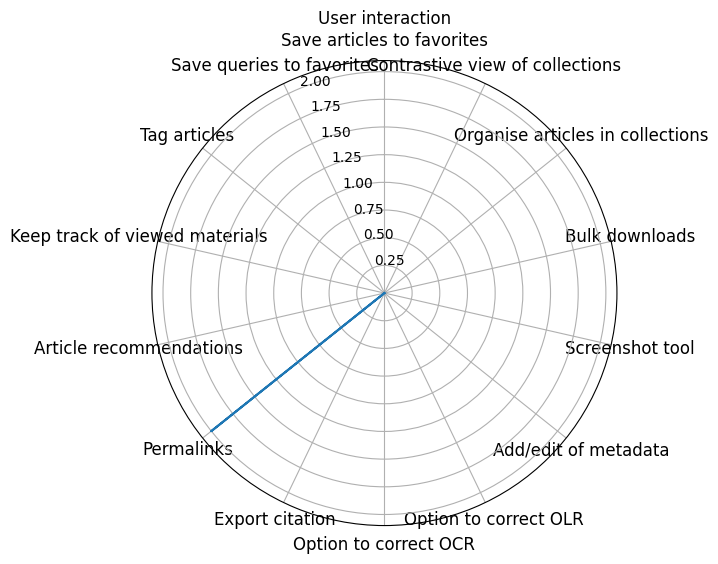

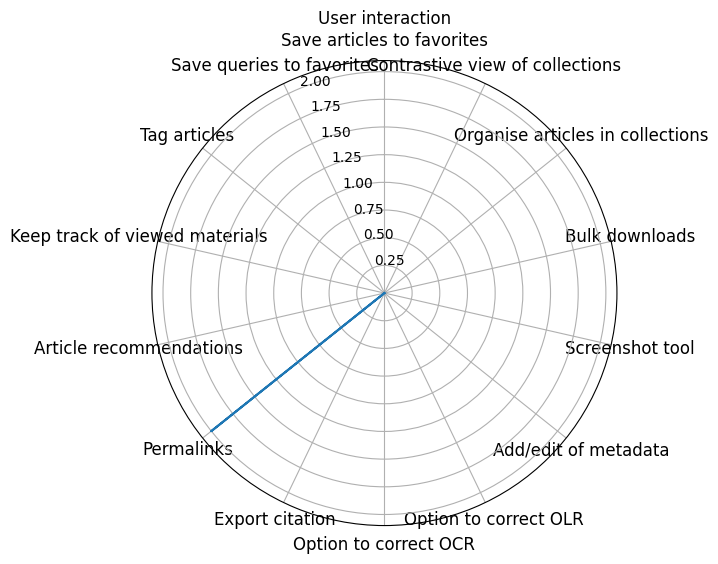

In [55]:
values_user = user.iloc[:,3:].T.values
build_single_radar_free(user.index, values_user, title="User interaction", figure_title="user-global", output_type='png')
build_single_radar_free(user.index, values_user, title="User interaction", figure_title="user-global", output_type='pdf')

#### Enrichment

In [56]:
enrich = base.loc['enrichment'].copy()
enrich = enrich.drop('Query')
enrich.loc[:,'Total'] = enrich.iloc[:, :3].sum(axis=1)
enrich['Total']

Property
NERC                                 0
Entity linking                       0
Automatic post-OCR correction        0
Crowd-sourced post-OCR correction    0
Topic Modeling                       0
Text re-use                          0
Sentiment Analysis                   0
Recommendations                      0
Event detection                      0
Name: Total, dtype: int64

In [57]:
enrich.iloc[:,4:]

Empty DataFrame
Columns: []
Index: [NERC, Entity linking, Automatic post-OCR correction, Crowd-sourced post-OCR correction, Topic Modeling, Text re-use, Sentiment Analysis, Recommendations, Event detection]

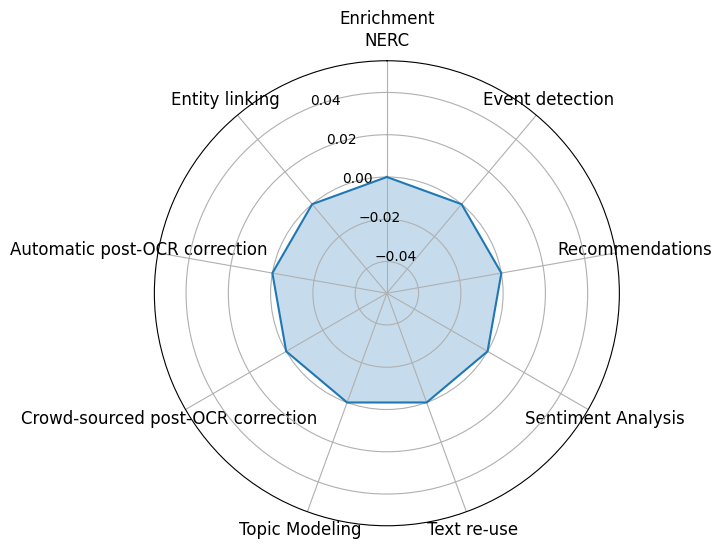

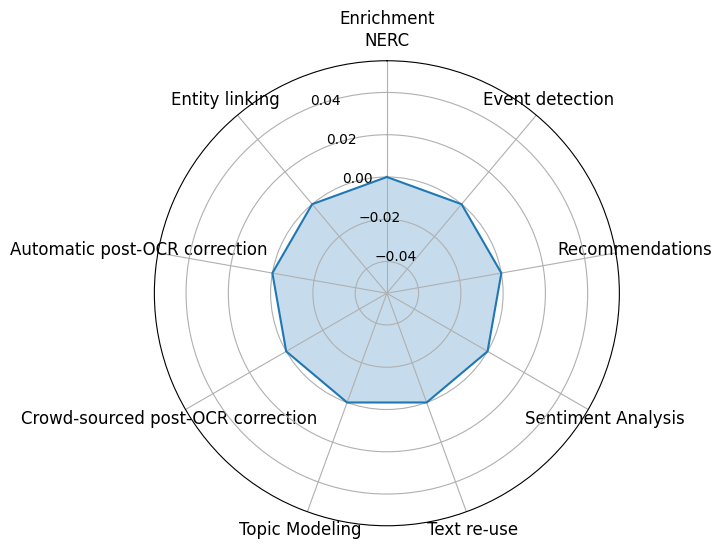

In [58]:
values_enrich = enrich.iloc[:,3:].T.values
build_single_radar_free(enrich.index, values_enrich, title="Enrichment", figure_title="enrichment-global", output_type='png')
build_single_radar_free(enrich.index, values_enrich, title="Enrichment", figure_title="enrichment-global", output_type='pdf')

#### Connectivity

In [59]:
conn = base.loc['connectivity'].copy()
conn.loc[:,'Total'] = conn.iloc[:, :3].sum(axis=1)
conn['Total']

Property
Third party identifiers        1
Links to other repositories    0
SW technologies                0
Name: Total, dtype: int64

In [60]:
conn.shape[0]

3

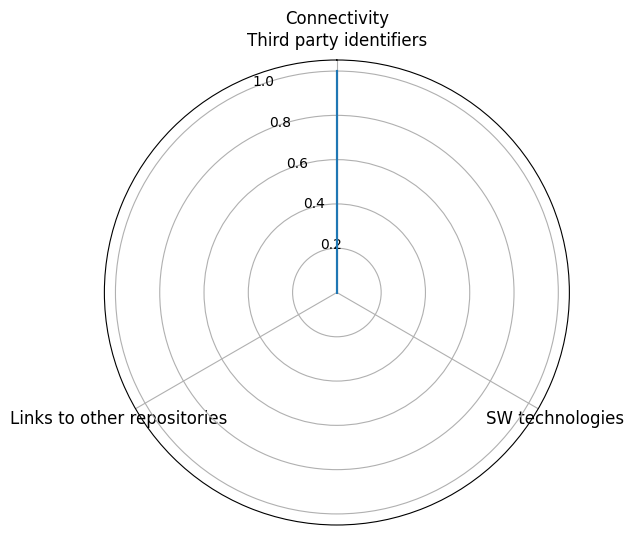

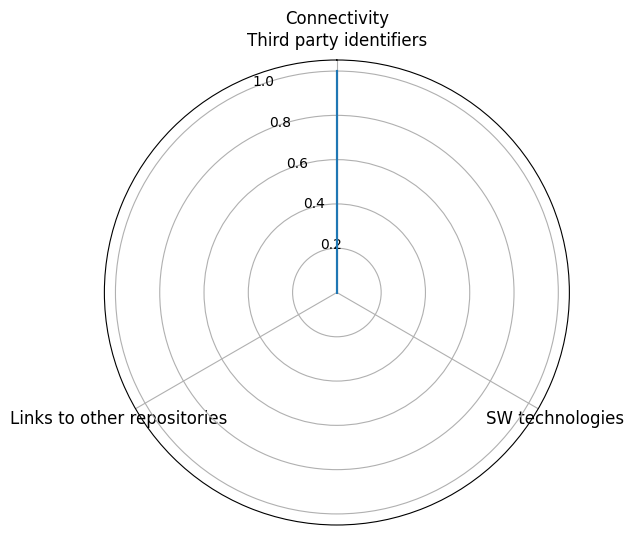

In [61]:
values_conn = conn.iloc[:,3:].T.values
build_single_radar_free(conn.index, values_conn, title="Connectivity", figure_title="connectivity-global", output_type='png')
build_single_radar_free(conn.index, values_conn, title="Connectivity", figure_title="connectivity-global", output_type='pdf')

#### APIs

In [62]:
apis = base.loc['apis'].copy()
apis.loc[:,'Total'] = apis.iloc[:, :3].sum(axis=1)
apis['Total']

Property
Link to source code of the interface    0
API                                     0
IIIF Image API                          0
IIIF Presentation API                   0
Name: Total, dtype: int64

In [63]:
apis.shape[0]

4

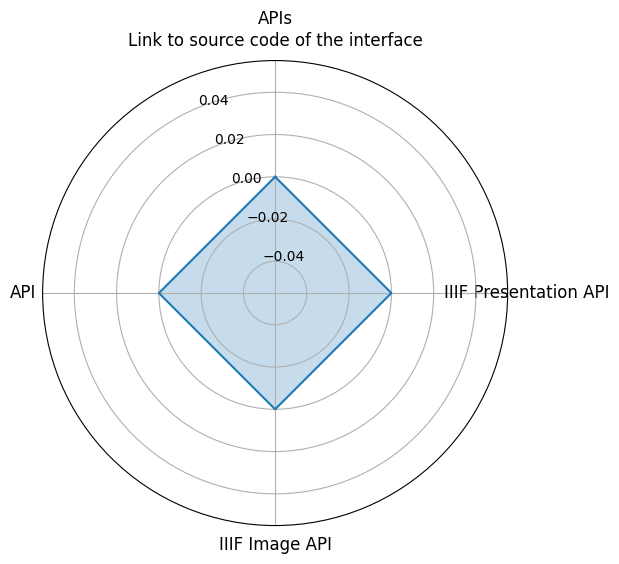

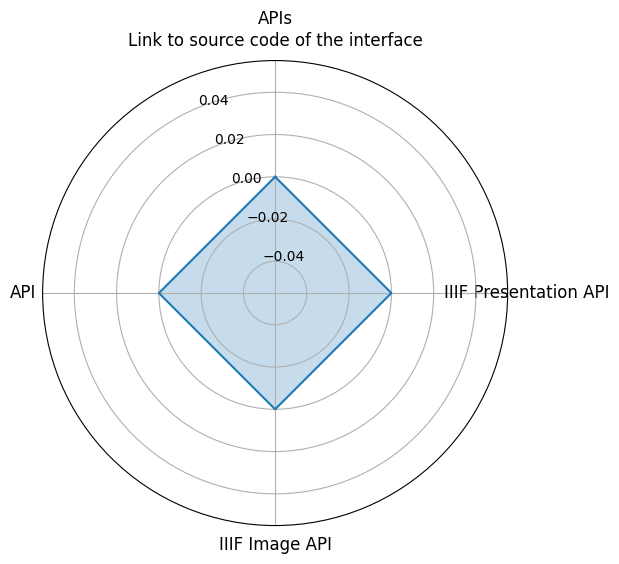

In [64]:
values_apis = apis.iloc[:,3:].T.values
build_single_radar_free(apis.index, values_apis, title="APIs", figure_title="apis-global", output_type='png')
build_single_radar_free(apis.index, values_apis, title="APIs", figure_title="apis-global", output_type='pdf')

### Mapping

In [68]:
base_mapping = pd.read_csv("../data/InterfaceReview-pt-2023-mapping.tsv", sep="\t", index_col= [0,1,2], skipinitialspace=True)

In [69]:
base_mapping.head()

Hemeroteca Digital Brasileira (HDB)  \
High level Criteria Property family Property                                                                          
Interfaces          interface       URL                                                   http://memoria.bn.br/hdb/   
                                    Target area                                                                  BR   
                                    Creator                                            Fundação Biblioteca Nacional   
                                    Purpose and scope             Coleção de periódicos digitalizados do acervo ...   
                                    Approximate date of creation                                               2012   

                                                                   Biblioteca Nacional Digital de Portugal (BND-PT)  \
High level Criteria Property family Property                                                                          
Interfaces          interface       URL                                        https://bndigital.bnportugal.gov.pt/   
                                    Target area                                                                  PT   
                                    Creator                                         Biblioteca Nacional de Portugal   
                                    Purpose and scope             Acervo digitalizado da Biblioteca Nacional de ...   
                                    Approximate date of creation                                                  u   

                                                                                 Hemeroteca Digital de Lisboa (HDL)  
High level Criteria Property family Property                                                                         
Interfaces          interface       URL                                     https://hemerotecadigital.cm-lisboa.pt/  
                                    Target area                                                                  PT  
                                    Creator                                                   Bibliotecas de Lisboa  
                                    Purpose and scope             Periódicos, legislação obras raras digitalizad...  
                                    Approximate date of creation                                                  u

In [70]:
# trim
base_mapping = trim_all_columns(base_mapping)

base_mapping = base_mapping.drop('Interfaces', level=0)
base_mapping = base_mapping.drop('Other', level=2)
base_mapping = base_mapping.drop('Download options (file formats)', level=2)
base_mapping = base_mapping.drop('Newspaper date range', level=2)
base_mapping = base_mapping.drop('Number of newspaper titles', level=2)

#Replace n and y by 0 and 1 (ideally to clean in spreadsheet)
base_mapping = base_mapping.replace(to_replace=['y', 'y?', 'y (annotations)', 'y (requires user account - free)', 'n', '?', 'u', 'n?', 'n (?)', 'n (but can signal mistakes)'], 
                   value=[1,1,1,1,0,0,0,0,0,0])

/tmp/ipykernel_314186/1114679381.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(trim_strings)
/tmp/ipykernel_314186/1042502492.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_mapping = base_mapping.replace(to_replace=['y', 'y?', 'y (annotations)', 'y (requires user account - free)', 'n', '?', 'u', 'n?', 'n (?)', 'n (but can signal mistakes)'],


In [71]:
mapping = base_mapping.groupby(level=0).sum(numeric_only=True)

In [72]:
mapping.loc[:,'Total'] = mapping.sum(axis=1)
mapping['Total (%)'] = mapping['Total']/mapping['Total'].sum() * 100

In [73]:
values = mapping.iloc[:,4]
values

High level Criteria
Connectivity                            3.092784
Content filtering                      15.463918
Content search                         32.989691
Generosity                              9.278351
Source criticism                       37.113402
User content management/exploration     2.061856
Name: Total (%), dtype: float64

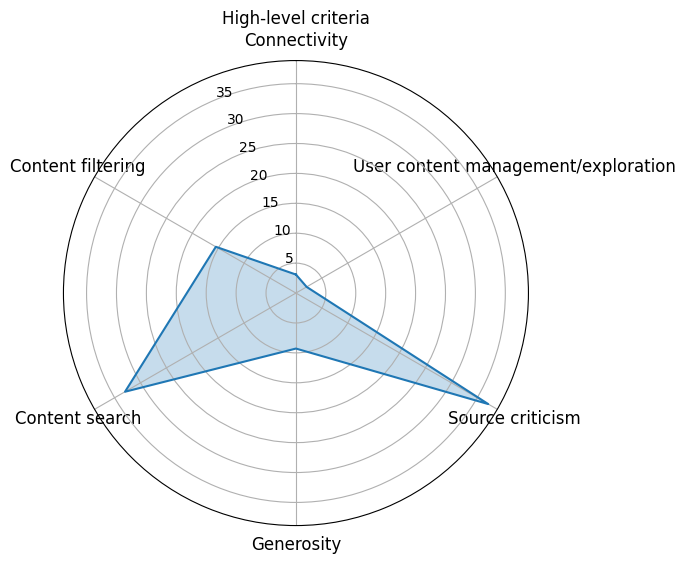

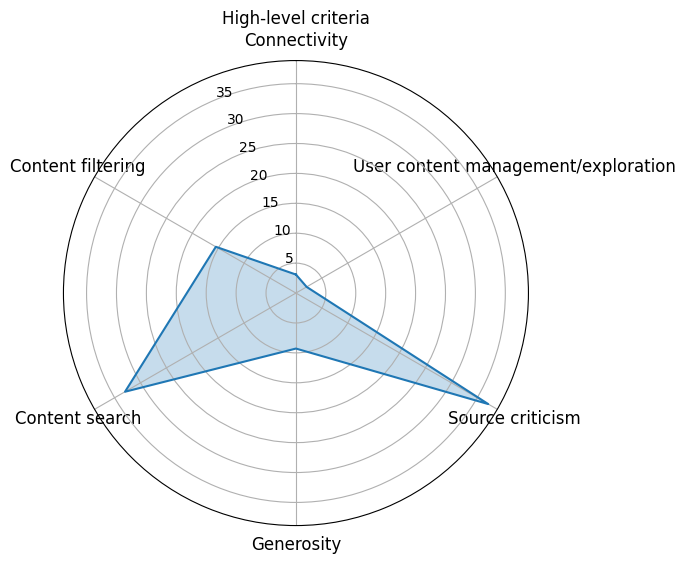

In [74]:
values = mapping.iloc[:,4:].T.values
build_single_radar_free(mapping.index, values, "High-level criteria",figure_title='high-level-criteria',output_type='png')
build_single_radar_free(mapping.index, values, "High-level criteria",figure_title='high-level-criteria',output_type='pdf')